In [1]:
%pylab inline
import pandas as pd
import seaborn as sns


Populating the interactive namespace from numpy and matplotlib


In [2]:
# import the results of the first post-process step
nfl_df = pd.read_csv(filepath_or_buffer='2_nfl_contracts_pre_process.csv',\
            header=0, index_col=0, dtype={'position': 'category', 'team': 'category', 'roster_status': 'category'})

In [3]:
# conform individual positions to broad categories of offense, defense and specialty
position_dict = {'WR':'offense', 'CB': 'defense', 'DE': 'defense', 'RB': 'offense', 'DT': 'defense', 'G': 'offense',
                 'TE':'offense', 'OLB': 'defense', 'ILB': 'defense', 'QB': 'offense', 'S': 'defense', 'C': 'offense',
                 'T': 'offense', 'LB': 'defense', 'RT': 'offense', 'SS': 'defense', 'FS': 'defense', 'LT': 'offense', 
                 'K': 'specialty', 'FB': 'offense', 'P': 'specialty', 'LS': 'specialty', 'KR': 'specialty', 'PR': 'specialty'}

In [4]:
# add position_group ("pos_group") to data frame
nfl_df['pos_group'] = nfl_df.position.map(position_dict)

In [5]:
# add intermediate grouping between pos_group and individual positions
sub_position_dict = {'WR':'skill', 'CB': 'secondary', 'DE': 'dline', 'RB': 'rb', 'DT': 'dline', 'G': 'oline',
                 'TE':'skill', 'OLB': 'lb', 'ILB': 'lb', 'QB': 'qb', 'S': 'secondary', 'C': 'oline',
                 'T': 'oline', 'LB': 'lb', 'RT': 'oline', 'SS': 'secondary', 'FS': 'secondary', 'LT': 'oline', 
                 'K': 'specialty', 'FB': 'rb', 'P': 'specialty', 'LS': 'specialty', 'KR': 'specialty', 'PR': 'specialty'}

nfl_df['pos_subgroup'] = nfl_df.position.map(sub_position_dict)

In [6]:
# combine certain roster_status values into fewer for analysis purposes (e.g., injured_reserve and non_fb injury into one category of "injured")
nfl_df['roster_status_adj']= nfl_df['roster_status']\
    .map({'injured_reserve': 'injured', 'non_fb_injury': 'injured', 'dead_cap': 'dead_cap', 'active': 'active', 'practice_squad': 'ps'})

In [7]:
nfl_df = nfl_df.astype({'roster_status_adj':'category', 'pos_group':'category', 'pos_subgroup': 'category'})

In [8]:
nfl_df.dtypes

base_salary             int64
bonus_total             int64
name                   object
position             category
roster_status        category
team                 category
total_money             int64
year                    int64
pos_group            category
pos_subgroup         category
roster_status_adj    category
dtype: object

In [9]:
# one category of "money" split is how much of a team's money is occupied by player's no longer on team (dead cap)
# or injured players (players on team but not able to play due to medical or other reasons)
roster_mask = (nfl_df['roster_status_adj'].isin(['dead_cap', 'injured'])) & (nfl_df['year'] != 2020)
disactive_rstr_df = nfl_df[roster_mask].groupby(['year', 'team', 'roster_status_adj'], as_index=False)['total_money'].sum().dropna()

In [10]:
# active players will have several different splits -> first pass will be offense versus defense, second pass will be particular positions 
active_rstr_mask = (nfl_df['roster_status_adj'] == 'active') & (nfl_df['year'] != 2020)
active_rstr_df = nfl_df[active_rstr_mask].groupby(['year', 'team','pos_group'], as_index=False)['total_money'].sum()

In [11]:
# rename separate "roster-like' columns to a single name before combining
active_rstr_df = active_rstr_df.rename({'pos_group': 'roster_type'}, axis='columns')
disactive_rstr_df = disactive_rstr_df.rename({'roster_status_adj': 'roster_type'}, axis='columns')

In [12]:
# combine the fellas
nfl_agg_df = pd.concat([active_rstr_df, disactive_rstr_df], axis='rows')

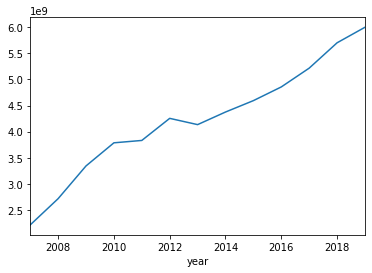

In [13]:
nfl_agg_df.groupby('year')['total_money'].sum().plot()

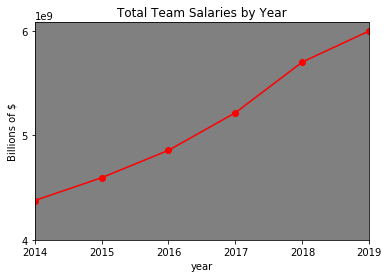

In [15]:
# figure for presentation
df = nfl_agg_df.loc[nfl_agg_df['year'].isin([2014, 2015, 2016, 2017, 2018, 2019]), :].groupby('year')['total_money'].sum()
ax = df.plot(kind='line', title='Total Team Salaries by Year', color='red', style='-o', yticks=[4_000_000_000, 5_000_000_000, 6_000_000_000], figsize=(6,4))
ax.set_ylabel('Billions of $')
ax.set_facecolor('gray')


In [16]:
# save figure to file
fig = ax.get_figure()
fig.savefig(r"C:\Users\jason\OneDrive\Documents\Jason\NYC Data Science Academy\projects\web_scraping\presentation\plots\line_chart.png")

In [17]:
# Calculate team total spend in order to compute relative %s for each "roster_status" category
team_totals = nfl_agg_df.groupby(['year', 'team'], as_index=False)['total_money'].sum()

In [18]:
team_totals = team_totals.rename({'total_money': 'team_total'}, axis='columns')

In [19]:
nfl_agg_df_w_total = pd.merge(left=nfl_agg_df, right=team_totals, on=['year', 'team'])

In [20]:
nfl_agg_df_w_total['perc_of_total'] = nfl_agg_df_w_total['total_money'] / nfl_agg_df_w_total['team_total']

In [21]:
# sample basis check these all total 1
nfl_agg_df_w_total.groupby(['year', 'team'])['perc_of_total'].sum().sample(5)

year  team               
2013  minnesota-vikings      1.0
2009  green-bay-packers      1.0
2013  washington-redskins    1.0
2018  detroit-lions          1.0
2008  arizona-cardinals      1.0
Name: perc_of_total, dtype: float64

In [22]:
# convert team and year columns to object type in prep for them to be turned into an index 
nfl_agg_df_w_total = nfl_agg_df_w_total.astype({'year': 'object', 'team': 'object'})

In [23]:
# let's make that index happen! combining these into one column
nfl_agg_df_w_total['yr_team'] = nfl_agg_df_w_total['year'].astype('str').str.cat(nfl_agg_df_w_total['team'] , sep='_')

In [24]:
nfl_agg_df_w_total.sample(5)

,year,team,roster_type,total_money,team_total,perc_of_total,yr_team
1498,2016,miami-dolphins,defense,54112645.0,154070498.0,0.351220,2016_miami-dolphins
1978,2019,miami-dolphins,defense,20348296.0,174461400.0,0.116635,2019_miami-dolphins
1817,2018,los-angeles-rams,injured,4444733.0,179879197.0,0.024710,2018_los-angeles-rams
1273,2015,chicago-bears,defense,34938909.0,140462358.0,0.248742,2015_chicago-bears
1880,2018,tennessee-titans,specialty,7718000.0,184308718.0,0.041875,2018_tennessee-titans


In [25]:
nfl_agg_df_w_total = nfl_agg_df_w_total.set_index('yr_team').drop(['year', 'team'], axis='columns')

In [26]:
nfl_agg_df_w_total.sample(5)

,roster_type,total_money,team_total,perc_of_total
yr_team,,,,
2011_dallas-cowboys,dead_cap,16110774.0,109904808.0,0.146588
2014_buffalo-bills,defense,70486049.0,155280760.0,0.453926
2013_houston-texans,specialty,2476610.0,133682230.0,0.018526
2016_cincinnati-bengals,injured,30543944.0,155833423.0,0.196004
2014_green-bay-packers,specialty,5476250.0,135644215.0,0.040372


In [27]:
# putting roster_type into columns in prep of interface with linear regression
features_df = nfl_agg_df_w_total.pivot(columns='roster_type', values='perc_of_total')

In [28]:
features_df.sample(5)

roster_type,dead_cap,defense,injured,offense,specialty
yr_team,,,,,
2012_atlanta-falcons,0.031639,0.433231,0.016176,0.493802,0.025152
2014_cincinnati-bengals,0.038282,0.516072,0.015746,0.396548,0.033353
2017_tampa-bay-buccaneers,0.047406,0.434918,0.140581,0.342973,0.034122
2008_cincinnati-bengals,0.068370,0.254136,0.017399,0.642844,0.017251
2011_los-angeles-chargers,0.011210,0.272310,0.071054,0.616722,0.028704


In [29]:
# bring in file associated with target variable (wins)
# read-in nfl standings from 2014 to 2019
nfl_wl_df = pd.read_csv('nfl_standings.csv', header=0, usecols=[0, 1, 2, 3, 4])


In [30]:
# add yr_team column and convert it to index in order to line up with the feature df
nfl_wl_df['yr_team'] = nfl_wl_df['year'].astype('str').str.cat(nfl_wl_df['team'], sep='_')
nfl_wl_df = nfl_wl_df.set_index('yr_team').drop(['year', 'team'], axis='columns')

In [31]:
nfl_wl_df.sample(5)

,w,l,playoff
yr_team,,,
2019_dallas-cowboys,8,8,no
2017_washington-redskins,7,9,no
2014_oakland-raiders,3,13,no
2017_baltimore-ravens,9,7,no
2019_new-england-patriots,12,4,yes


In [32]:
# brining target and features together
ftr_trgt_df = pd.merge(left=features_df, right=nfl_wl_df, left_index=True, right_index=True, sort=False, how='inner')

In [33]:
ftr_trgt_df.sample(5)

,dead_cap,defense,injured,offense,specialty,w,l,playoff
yr_team,,,,,,,,
2018_tennessee-titans,0.080437,0.312622,0.278576,0.286489,0.041875,9,7,no
2017_new-york-jets,0.143048,0.427968,0.176827,0.238929,0.013228,5,11,no
2018_los-angeles-rams,0.093538,0.497254,0.024710,0.342368,0.042131,13,3,yes
2017_cincinnati-bengals,0.025845,0.403701,0.176229,0.363142,0.031085,7,9,no
2014_arizona-cardinals,0.110053,0.360595,0.126284,0.389007,0.014062,11,5,yes


In [34]:
# write out to csv to derive visualizations
ftr_trgt_df.to_csv(path_or_buf='3_post_data_clean.csv', index_label='yr_team')

In [35]:
nfl_agg_df_w_total.sample(5)

,roster_type,total_money,team_total,perc_of_total
yr_team,,,,
2018_new-orleans-saints,defense,52086938.0,176612149.0,0.294923
2012_new-england-patriots,offense,56141355.0,132712695.0,0.423029
2011_washington-redskins,dead_cap,16229148.0,130437856.0,0.124421
2018_minnesota-vikings,specialty,3230000.0,189999661.0,0.017000
2010_new-england-patriots,specialty,3021812.0,110637563.0,0.027313


In [36]:
nfl_agg_df_w_total['roster_type'].unique()

array(['defense', 'offense', 'specialty', 'dead_cap', 'injured'],
      dtype=object)

In [39]:
boxplot_df = pd.merge(left=nfl_agg_df, right=team_totals, on=['year', 'team'])
boxplot_df.sample(5)

,year,team,roster_type,total_money,team_total
1636,2017,indianapolis-colts,dead_cap,27734763.0,156717016.0
612,2010,tampa-bay-buccaneers,dead_cap,17139714.0,90503927.0
1306,2015,green-bay-packers,dead_cap,5436397.0,142399637.0
1017,2013,los-angeles-rams,injured,7983254.0,127064329.0
1129,2014,dallas-cowboys,offense,55808424.0,135963478.0


In [41]:
boxplot_df['perc_of_total'] = boxplot_df['total_money'] / boxplot_df['team_total']

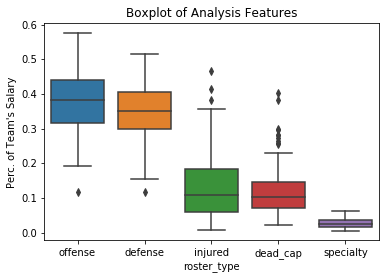

In [42]:
boxplot_df = boxplot_df.loc[boxplot_df['year'].isin([2014, 2015, 2016, 2017, 2018, 2019]), :]
ax = sns.boxplot(x='roster_type', y='perc_of_total', data=boxplot_df, order=['offense', 'defense', 'injured', 'dead_cap', 'specialty'])
ax.set_title('Boxplot of Analysis Features')
ax.set_ylabel("Perc. of Team's Salary")
fig = ax.get_figure()
fig.savefig(r"C:\Users\jason\OneDrive\Documents\Jason\NYC Data Science Academy\projects\web_scraping\presentation\plots\boxplot_features.png")